In [2]:
import rasterio
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import rasterio.mask
import cartopy.crs as ccrs
import matplotlib as mpl
import pyproj


### Read DEM data

In [3]:
dem_raw_data = rasterio.open("./data/tiff/part.tif")

dem_crs = dem_raw_data.crs
dem_transform = dem_raw_data.transform
dem_bounds = dem_raw_data.bounds
nodata_value = dem_raw_data.nodata

In [270]:
dem_crs

CRS.from_wkt('PROJCS["WGS 84 / UTM zone 47N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",99],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32647"]]')

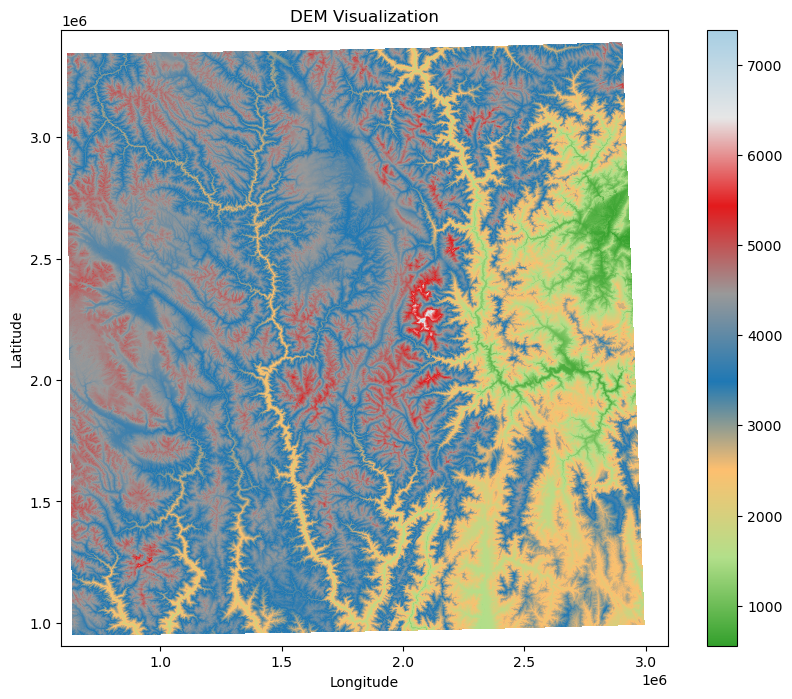

In [ ]:
# read the first band of DEM data
dem_data = dem_raw_data.read(1)
dem_data = np.where(dem_data == nodata_value, np.nan, dem_data)

min_value = np.nanmin(dem_data)
max_value = np.nanmax(dem_data)

# create a colormap
colors = ["#33A02C", "#B2DF8A", "#FDBF6F", "#1F78B4", "#999999", "#E31A1C", "#E6E6E6", "#A6CEE3"]
cmap = mpl.colors.LinearSegmentedColormap.from_list("mypalette", colors, N=1000)

fig, ax = plt.subplots(figsize=(10, 8))

# plot the DEM data
cbar = ax.imshow(dem_data, cmap=cmap, interpolation='nearest', origin='upper', extent=dem_bounds)

fig.colorbar(cbar, ax=ax, orientation='vertical')

ax.set_title("DEM Visualization")
# ax.set_xlabel("Longitude")
# ax.set_ylabel("Latitude")

plt.show()


### Read map

In [4]:
map = gpd.read_file("./data/geo/中国县界.shp")
map.head()

,AREA,PERIMETER,PROVINCE,NAME,ENAME,GB1999,TOWNS,COMMUNITY,FAMILIES,FAM_COU,...,popu10000,INDUPRODUC,popu_per_1,LIGHTPRODU,popucou_pe,stu_per__1,popwork_pe,tel_per_fa,POST_,geometry
0,1.810167e+10,665425.69,23,南充市,mohexian,440825,17.0,173.0,155975.0,109971.0,...,660000,63600,337.769012,71,80.303001,21.0835,5.981100,31.4345,165300,"POLYGON ((1053852.278 6333231.292, 1057709.701..."
1,1.416603e+10,583142.81,23,塔河县,tahexian,232722,3.0,17.0,30827.0,2363.0,...,100000,47800,7.112881,6077,10.000000,13.5760,22.541000,62.3512,165200,"POLYGON ((1226011.307 6375310.175, 1228541.954..."
2,3.041504e+10,1277285.30,15,额尔古纳右旗,geergunyouqi,152105,0.0,0.0,53052.0,0.0,...,170000,14076,8.494903,5674,0.000000,13.8006,4.477600,45.1086,222500,"POLYGON ((1053852.278 6333231.292, 1055119.89 ..."
3,3.159027e+10,1209216.40,23,呼玛县,humaxian,232721,10.0,68.0,14819.0,6508.0,...,50000,15000,3.505820,462,40.000000,14.6080,14.166000,63.4321,165100,"POLYGON ((1191527.859 6256622.078, 1195797.636..."
4,1.980711e+10,839650.75,15,额尔古纳左旗,geergunzuoqi,152106,4.0,4.0,24435.0,465.0,...,80000,7330,2.857143,4270,0.000000,15.5025,23.653799,60.5975,223500,"POLYGON ((1091537.215 6237224.8, 1092104.588 6..."


In [5]:
county_name = "雅江县"
county_boundary = map[map["NAME"] == county_name]
county_boundary.crs

<Projected CRS: PROJCS["China_Lambert_Conformal_Conic",GEOGCS["Bei ...>
Name: China_Lambert_Conformal_Conic
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Lambert Conic Conformal (2SP)
Datum: Beijing 1954
- Ellipsoid: Krassowsky 1940
- Prime Meridian: Greenwich

In [6]:
# check if the crs of county_boundary is the same as dem_crs
if county_boundary.crs != dem_crs:
    county_boundary = county_boundary.to_crs(dem_crs)
county_geometry = [geom for geom in county_boundary["geometry"]]

### Crop DEM data 

In [7]:
# crop the DEM data with the boundary of the county
out_image, out_transform = rasterio.mask.mask(dem_raw_data, county_geometry, crop=True)  
out_meta = dem_raw_data.meta.copy() 
out_meta.update({ 
    "driver": "GTiff",
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform
})


In [ ]:
clean_data = out_image.copy().astype('float')
clean_data = np.ma.masked_equal(clean_data, nodata_value)  # mask the nodata value

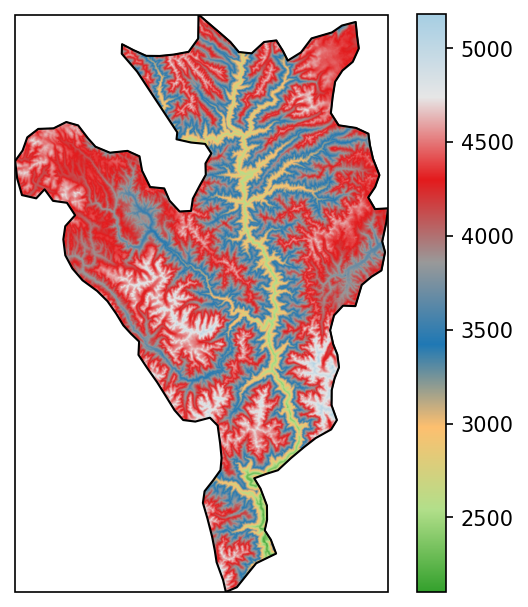

In [9]:
# 定义地图投影 (使用与 DEM 数据相同的投影)
myccrs = ccrs.UTM(zone=47, southern_hemisphere=False)  # UTM 47N
extent = [out_transform[2], out_transform[2] + clean_data.shape[2] * out_transform[0], 
          out_transform[5] + clean_data.shape[1] * out_transform[4], out_transform[5]]

fig, ax = plt.subplots(figsize=(5, 5), dpi=150, subplot_kw={'projection': myccrs})

# plot the DEM data
ax.imshow(clean_data[0], origin='upper', extent=extent,
          cmap=mpl.cm.terrain)

# plot the boundary of the county
county_boundary.boundary.plot(ax=ax, color='black', linewidth=1)

# define a colormap
colors = ["#33A02C", "#B2DF8A", "#FDBF6F", "#1F78B4", "#999999", "#E31A1C", "#E6E6E6", "#A6CEE3"]
cmap = mpl.colors.LinearSegmentedColormap.from_list("mypalette", colors, N=1000)
cmap.set_under("white")  # set the minimum value to white, which is the nodata value

fig.colorbar(ax.imshow(clean_data[0], origin='upper', extent=extent,
                       cmap=cmap), ax=ax)


plt.show()